In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from segmentflow import segment, view
from skimage import color
from stl import mesh
%load_ext autoreload
%autoreload 2

In [3]:
img_dir_path = Path('../data/SandComp4_18_22/NoComptiff/')
save_dir_path = Path('../data/SandComp4_18_22/')

## Generate STLs

Loading images...
--> Images loaded as 3D array:  (50, 50, 50)
Plotting images: [0, 12, 24, 36]


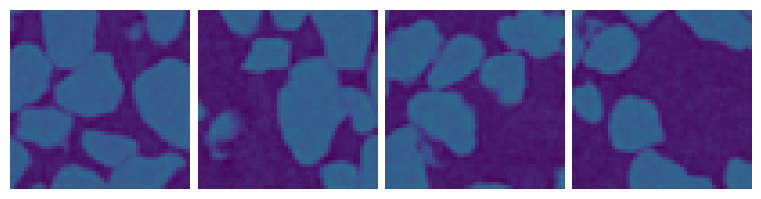

In [3]:
# row & col crop deterined in NB 09
imgs = segment.load_images(
    img_dir_path,
    slice_crop=[125, 175],
    row_crop=[450, 500],
    col_crop=[200, 250],
    convert_to_float=True,
    file_suffix='.tiff'
)
fig, axes = view.plot_slices(
    imgs,
    nslices=4,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

Binarizing images...
--> Calculating Otsu threshold(s)...
--> Binarization complete.
Plotting images: [0, 12, 24, 36]


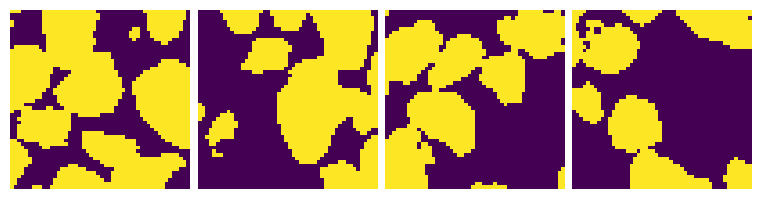

In [4]:
imgs_bw, thresh_vals = segment.binarize_multiotsu(imgs, n_otsu_classes=2)
fig, axes = view.plot_slices(
    imgs_bw,
    nslices=4,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

Segmenting images...
--> Number of particle(s) before border exclusion:  23
--> Excluding border particles...
--> Segmentation complete. 3 particle(s) segmented.
Plotting images: [0, 12, 24, 36]


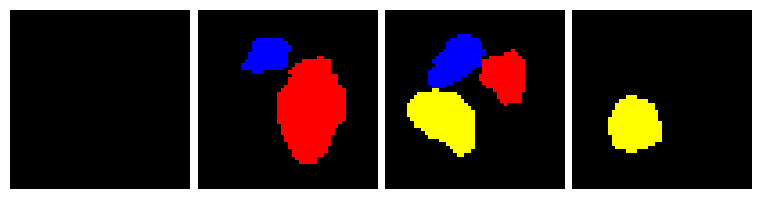

In [5]:
imgs_seg = segment.watershed_segment(
    imgs_bw,
    min_peak_distance=7,
    exclude_borders=True,
    return_dict=False
)
imgs_seg_color = color.label2rgb(imgs_seg)
fig, axes = view.plot_slices(
    imgs_seg_color,
    nslices=4,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

In [6]:
segment.save_as_stl_files(
    imgs_seg,
    save_dir_path,
    f'{img_dir_path.stem}-',
    make_new_save_dir=True
)

Generating surface meshes...
Meshes not generated. Directory already exists:
C:\Users\gusb\Research\mhe-analysis\data\SandComp4_18_22\NoComptiff-STLs


## Dev vector assembly

In [4]:
stl_dir_path = Path(f'{save_dir_path}/{img_dir_path.stem}-STLs')
stl_dir_list = [path for path in stl_dir_path.glob('*.stl')]
stl_dir_list.sort()
stl_path = stl_dir_list[0]
stl_mesh = mesh.Mesh.from_file(stl_path)
print(stl_mesh.vectors.shape)
print(stl_mesh.vectors[0])
print(stl_mesh.v0.shape)
print(stl_mesh.v0)

(5568, 3, 3)
[[32.  21.5  6. ]
 [31.5 22.   6. ]
 [32.  22.   5.5]]
(5568, 3)
[[32.  21.5  6. ]
 [32.  22.   5.5]
 [31.  22.5  6. ]
 ...
 [36.  18.5 29. ]
 [37.  18.5 29. ]
 [37.  18.5 29. ]]


In [5]:
test = stl_mesh.vectors[:2]
print(test.shape)
print(test)
test1 = test.reshape((test.shape[0] * test.shape[2], test.shape[1]))
print(test1)
print(np.unique(test1, axis=0))

(2, 3, 3)
[[[32.  21.5  6. ]
  [31.5 22.   6. ]
  [32.  22.   5.5]]

 [[32.  22.   5.5]
  [32.5 22.   6. ]
  [32.  21.5  6. ]]]
[[32.  21.5  6. ]
 [31.5 22.   6. ]
 [32.  22.   5.5]
 [32.  22.   5.5]
 [32.5 22.   6. ]
 [32.  21.5  6. ]]
[[31.5 22.   6. ]
 [32.  21.5  6. ]
 [32.  22.   5.5]
 [32.5 22.   6. ]]


In [6]:
# -1 in np.reshape() infers remaining dimension from size of original array
vectors = stl_mesh.vectors.reshape((-1, stl_mesh.vectors.shape[1]))
print(vectors.shape)
vectors = np.unique(vectors, axis=0)
print(vectors.shape)

(16704, 3)
(2786, 3)


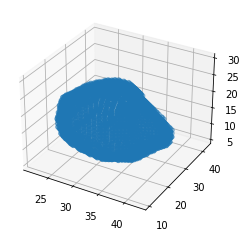

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2])

[31.602297 25.400574 15.779613]


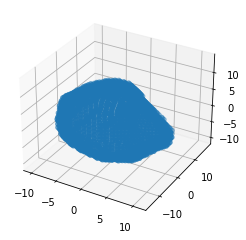

In [8]:
center = np.mean(vectors, axis=0)
print(center)
centered = vectors - center
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(centered[:, 0], centered[:, 1], centered[:, 2])

In [13]:
dyadic = np.outer(centered, centered)
print(dyadic.shape)
evals, evals_norm = np.linalg.eig(dyadic)


(8358, 8358)


In [28]:
tp_0 = np.tensordot(centered[:, 0], centered[:, 0], axes=0)
print(tp_0.shape)

(2786, 2786)


In [13]:
tp = np.tensordot(centered, centered, axes=0)
print(tp.shape)

(2786, 3, 2786, 3)


In [21]:
tp_sliced = tp[0, 1]
tp_sliced.shape

(2786, 3)

In [22]:
tp_avg = np.mean(tp_sliced, axis=0)
tp_avg

array([-2.3906896e-06, -1.3503169e-05,  9.3661874e-06], dtype=float32)

In [25]:
tp_m = np.tensordot(tp_avg, tp_avg, axes=0)
print(tp_m)

[[ 5.7153969e-12  3.2281885e-11 -2.2391648e-11]
 [ 3.2281885e-11  1.8233556e-10 -1.2647321e-10]
 [-2.2391648e-11 -1.2647321e-10  8.7725466e-11]]


In [26]:
evals, evals_norm = np.linalg.eig(tp_m)
print(evals)

[ 2.7577643e-10  7.0304060e-19 -2.9391593e-19]


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(dyadic[:, 0], dyadic[:, 1], dyadic[:, 2])